In [37]:
import matplotlib.pyplot as plt
from tsfresh import extract_features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm
import os

### 7.1 分类问题

In [56]:
current_path = os.getcwd()
eeg = pd.read_csv(f'{current_path}/data/eeg.csv')
# eeg[(eeg.classes=='F') & (eeg.id==300)].shape
# eeg.groupby(['classes', 'id'])['id'].count()
eeg.head()

,id,times,measurements,classes
0,0,0.000000,40.0,Z
1,0,0.005762,48.0,Z
2,0,0.011523,35.0,Z
3,0,0.017285,5.0,Z
4,0,0.023047,-40.0,Z


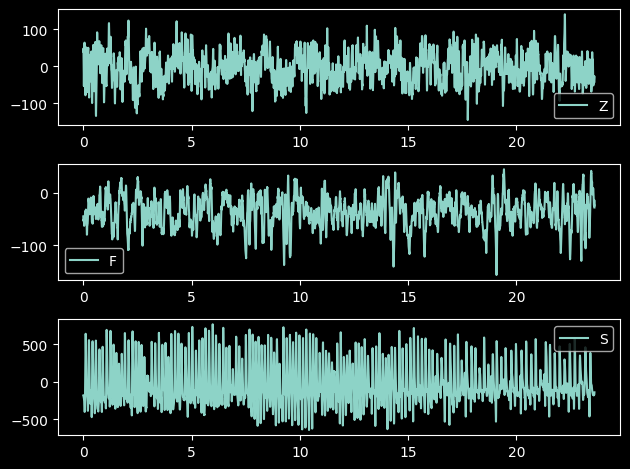

In [39]:
# 观察不同类别的时间序列特征，为后面构造特征做准备
plt.subplot(3, 1, 1)
plt.plot(eeg[eeg.id==0]['times'], eeg[eeg.id==0]['measurements'])
plt.legend(eeg.loc[0,'classes'])
plt.subplot(3, 1, 2)
plt.plot(eeg[eeg.id==300]['times'],eeg[eeg.id==300]['measurements'])
plt.legend(eeg.loc[300*4097,'classes'])
plt.subplot(3, 1, 3)
plt.plot(eeg[eeg.id==450]['times'],eeg[eeg.id==450]['measurements'])
plt.legend(eeg.loc[450*4097,'classes'])
plt.tight_layout()

In [40]:
# 抽取特征
fc_parameters = {
    "skewness": None,
    "ratio_beyond_r_sigma": [{"r": 1}],
    "maximum":None,
    "minimum":None,
    "mean_abs_change":None,
    "longest_strike_above_mean":None
}
data = extract_features(eeg, column_id = "id",column_sort = "times",column_value="measurements",chunksize=20, default_fc_parameters=fc_parameters)

Feature Extraction: 100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


In [41]:
data.index.names=['id']
data.reset_index()
data = data.merge(eeg[['id','classes']].drop_duplicates(), on='id',how='inner')
data.head(10)

   id  measurements__skewness  measurements__ratio_beyond_r_sigma__r_1  \
0   0                0.032817                                 0.327313   
1   1               -0.092749                                 0.290212   
2   2               -0.004101                                 0.302660   
3   3                0.063701                                 0.300952   
4   4                0.142806                                 0.305101   
5   5                0.002502                                 0.308763   
6   6                0.003180                                 0.308518   
7   7               -0.023605                                 0.324628   
8   8               -0.002427                                 0.324140   
9   9                0.202725                                 0.302172   

   measurements__maximum  measurements__minimum  \
0                  141.0                 -146.0   
1                  169.0                 -254.0   
2                  184.0        

In [6]:
# 训练机器学习模型
X_train, X_test, y_train, y_test = train_test_split(data.drop(['id', 'classes'], axis=1), data["classes"])
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
# 模型评估
rf_clf.score(X_test, y_test)

0.768

In [8]:
# 使用XGBOOST模型
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

c:\users\skywater\pycharmprojects\personal\py39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.72

### 7.2 聚类问题

In [9]:
# 归一化数据
data_cluster = data.drop(['id', 'classes'], axis=1)
data_values = preprocessing.scale(data_cluster.values)

In [10]:
# 使用第一类聚类思路进行层次聚类
clustering = AgglomerativeClustering(n_clusters = 5,linkage = 'ward')
clustering.fit(data_values)

AgglomerativeClustering(n_clusters=5)

In [11]:
# 输出模型评估指标
homogeneity_score(clustering.labels_, data.classes)

0.4367253979317053

In [38]:
rowlist= np.array(range(0,50))
for a in [np.array(range(100,150)),np.array(range(200,250)),np.array(range(300,350)),np.array(range(400,450))]:
    rowlist=np.append(rowlist,a)

In [47]:
# 使用第二类聚类思路首先计算DTW距离，这一步计算量比较大，先把结果存下来，并且作为简化，只选择了部分数据送入模型
pairwise_dis = pd.DataFrame(np.zeros((250, 250)))
for index_r, r in tqdm(enumerate(rowlist)):
    for index_c, c in enumerate(rowlist):
        arr1 = eeg[eeg.id==r]['measurements'].values[:500]
        arr2 = eeg[eeg.id==c]['measurements'].values[:500]
        distance, _ = fastdtw(arr1, arr2, dist=euclidean)
        pairwise_dis.iloc[index_r,index_c]=distance

250it [3:21:01, 48.25s/it]


In [52]:
pairwise_dis.to_csv('data/pairwise_dis.csv',index=False)
pairwise_distance = pd.read_csv('data/pairwise_dis.csv')

In [53]:
# 使用第二类聚类思路进行层次聚类
dtw_clustering = AgglomerativeClustering(linkage = 'average',n_clusters = 5, affinity = 'precomputed')
_=dtw_clustering.fit_predict(pairwise_distance)

In [65]:
# 输出模型评估指标
homogeneity_score(dtw_clustering.labels_, data[data.index.isin(rowlist)]['classes']) 

0.32086816047177635